In [1]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

# Manifold Statistics - Examples on $\mathbb{S}^2$

In [2]:
from src.manifolds.S2 import *
M = S2()
print(M)

from src.plotting import *

2d sphere (ellipsoid parameters [1. 1. 1.], spherical_coords: False)


In [3]:
# Riemannian structure
from src.Riemannian import metric
metric.initialize(M)

# geodesics
from src.Riemannian import geodesic
geodesic.initialize(M)

# Logarithm map
from src.Riemannian import Log
Log.initialize(M)

using M.Exp for Logarithm


ERROR (theano.gof.opt): Optimization failure due to: local_useless_dimshuffle_in_reshape
ERROR (theano.gof.opt): node: Reshape{2}(InplaceDimShuffle{0,1}.0, <TensorType(int64, vector)>)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/stefan/projects/theanogeometry/lib/python3.6/site-packages/theano/gof/opt.py", line 2074, in process_node
    remove=remove)
  File "/home/stefan/projects/theanogeometry/lib/python3.6/site-packages/theano/gof/toolbox.py", line 569, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/home/stefan/projects/theanogeometry/lib/python3.6/site-packages/theano/gof/toolbox.py", line 518, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/home/stefan/projects/theanogeometry/lib/python3.6/site-packages/theano/gof/fg.py", line 486, in replace
    ". The type of the replacement must be the same.", old, new)
theano.gof.toolb

## Sample Data

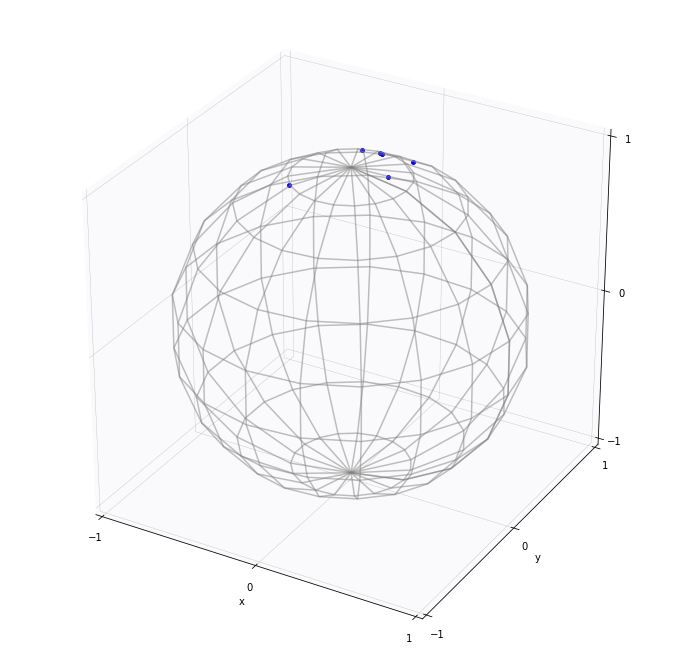

In [4]:
# coordinate form
from src.stochastics import Brownian_coords
Brownian_coords.initialize(M)

var = .2
n_steps.set_value(1000)

N_samples = 6
x = M.coordsf([0.,0.])

obss = np.zeros((N_samples,M.dim.eval()))
obs_charts = np.zeros((N_samples,)+x[1].shape)
for i in range(N_samples):
    (ts,xs,charts) = M.Brownian_coordsf(x,var*dWsf(M.dim.eval()))
    obss[i] = xs[-1]
    obs_charts[i] = charts[-1]

# plot
newfig()
M.plot()
for i in range(N_samples):
    M.plotx((obss[i],obs_charts[i]))
plt.show()

## Frechet mean

         Current function value: 0.019169
         Iterations: 1
         Function evaluations: 105
         Gradient evaluations: 93
loss =  0.019169199012039274
mean =  (array([0.00364622, 0.09386874]), array([0., 0., 1.]))


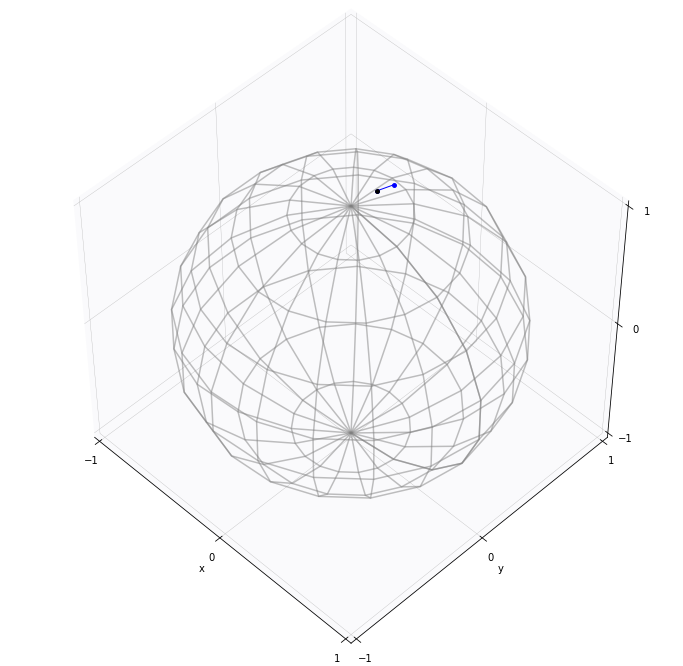

In [5]:
from src.statistics.Frechet_mean import *

res = Frechet_mean(lambda *args: M.Logf(*args),zip(obss,obs_charts),options={'maxiter': 10, 'disp': True})
Fm = res[0]
print("loss = ", res[1])
print("mean = ", Fm)
iterations = res[2]

newfig()
M.plot(rotate = np.array([50,-45]))
M.plot_path(zip(iterations,itertools.cycle((Fm[1],))))
M.plotx(Fm,color='black')
plt.show()

## Tangent PCA

[[0.00181878 0.00129722]
 [0.00129722 0.00385188]]


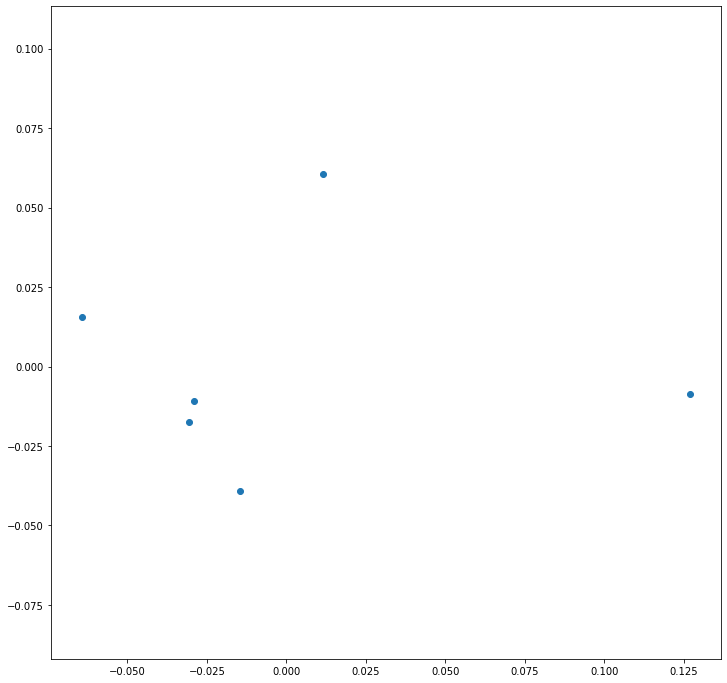

In [7]:
# from src.statistics.Tangent_PCA import *

from src.utils import *
from sklearn.decomposition import PCA

pca = tangent_PCA(M,lambda *args: M.Logf(*args),x,zip(obss,obs_charts))
print(pca.get_covariance())

plt.scatter(pca.transformed_Logs[:, 0], pca.transformed_Logs[:, 1])
plt.axis('equal')
plt.show()

# ML mean estimation

In [8]:
# Delyon/Hu guided process
from src.stochastics.guided_process import *

# guide function
Cholesky = T.slinalg.Cholesky()
phi = lambda q,v: T.tensordot(Cholesky(M.g(q)).T,M.StdLog(q,v).flatten(),(1,0))

(Brownian_coords_guided,Brownian_coords_guidedf) = get_guided_likelihood(
    M,M.sde_Brownian_coords,phi,lambda x: Cholesky(M.gsharp(x)),A=lambda x,v,w: T.tensordot(v,T.tensordot(M.g(x),w,1),1),
    use_charts=True,chart_update=M.chart_update_Brownian_coords)     


In [9]:
options = {}
options['samples_per_obs'] = 1
options['epochs'] = 75
options['learning_rate'] = .5e-0
options['varphi_update_rate'] = 1.
options['initial'] = [M.update_coordsf(x,M.chartf())[0]+.1*np.random.randn(M.dim.eval())]
options['verbose'] = True

In [10]:
# transition density etc.
q0 = M.sym_coords()
v = M.sym_coords()
chart = M.sym_chart()
thetas = (q0,)
_log_p_Tf = theano.function([q0,chart,v],log_p_T((q0,chart),v,dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords,F=M.F,use_charts=True))
_dlog_p_Tf = theano.function([q0,chart,v],dlog_p_T(thetas,(q0,chart),v,dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords,F=M.F,use_charts=True))
_p_Tf = theano.function([q0,chart,v],T.exp(log_p_T((q0,chart),v,.7*dWs(M.dim),Brownian_coords_guided,phi,options,sde=M.sde_Brownian_coords,F=M.F,use_charts=True)))
log_p_Tf = lambda x,v: _log_p_Tf(x[0],x[1],v)
dlog_p_Tf = lambda x,v: _dlog_p_Tf(x[0],x[1],v)
p_Tf = lambda x,v: _p_Tf(x[0],x[1],v)

v = x
print(x)
print(v)
%time print(log_p_Tf(x,v[0]))
%time print(p_Tf(x,v[0]))
%time print(dlog_p_Tf(x,v[0]+.1*np.random.randn(M.dim.eval())))

transition density with v constant
transition density with v constant
transition density with v constant
(array([0., 0.]), array([0., 0., 1.]))
(array([0., 0.]), array([0., 0., 1.]))
-1.098615369699253
CPU times: user 2.9 s, sys: 6.79 ms, total: 2.91 s
Wall time: 2.91 s
0.17678858954629956
CPU times: user 2.87 s, sys: 2.96 ms, total: 2.87 s
Wall time: 2.87 s
[array(-1.12138474), array([-0.82762467, -0.07631038])]
CPU times: user 36.8 s, sys: 45.4 ms, total: 36.8 s
Wall time: 36.8 s


In [11]:
from src.statistics.mle import *

def llog_p_T(thetas,pars):
    (obs,seed) = pars
    if seed:
        srng.seed(seed)
    v = (obs[0:M.dim.eval()],obs[M.dim.eval():])
    q = M.coordsf(thetas[0])
    qchartv = M.update_coordsf(q,v[1])
    res = dlog_p_Tf(qchartv,v[0])
    return (res[0],M.update_vectorf(qchartv,q,res[1]))

def update_thetas(thetas, dthetas):
    q = (thetas[0],M.chartf())
    
    new_q = q[0]+options['learning_rate']*np.dot(M.gsharpf(q),dthetas[0]) # use Riemannian g-gradient
    
    return (new_q,)

In [12]:
# run MLE
n_steps.set_value(50)
(thetas, log_likelihood, log_likelihoods, thetass) = iterative_mle(obss,llog_p_T,update_thetas,options)

# plot
plt.plot(range(options['epochs']),log_likelihoods)
# plt.savefig('ML_likelihoods.pdf')
plt.show()
plt.plot(range(options['epochs']),thetass[0].reshape((thetass[0].shape[0],-1)))
# plt.savefig('ML_thetas.pdf')
plt.show()

M.newfig()
M.plot()
M.plotx(M.coordsf(options['initial'][0]),color='k',s=100)
M.plotx(M.coordsf(thetass[0][-1]),color='b',s=100)
M.plotx(x,color='r',s=100)
M.plot_path([M.coordsf(thetass[0][i]) for i in range(options['epochs'])],color='b',linewidth=2.5)

plt.savefig('MLmean_iterations.pdf')
plt.show()

n_steps.set_value(100)

initial thetas: (array([0.04943914, 0.21999381]),)


ValueError: attempt to get argmax of an empty sequence
Apply node that caused the error: Argmax{axis=(0,)}(Elemwise{Composite{(-Abs(i0))}}.0)
Toposort index: 14
Inputs types: [TensorType(float64, vector)]
Inputs shapes: [(0,)]
Inputs strides: [(8,)]
Inputs values: [array([], dtype=float64)]
Outputs clients: [[ScalarFromTensor(argmax)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "<ipython-input-2-42c0a4f5085a>", line 2, in <module>
    M = S2()
  File "/home/stefan/projects/theanogeometry/src/manifolds/S2.py", line 34, in __init__
    Ellipsoid.__init__(self,params=[1.,1.,1.],chart_center=chart_center,use_spherical_coords=use_spherical_coords)
  File "/home/stefan/projects/theanogeometry/src/manifolds/ellipsoid.py", line 98, in __init__
    EmbeddedManifold.__init__(self,F,2,3,invF=invF)
  File "/home/stefan/projects/theanogeometry/src/manifolds/manifold.py", line 181, in __init__
    self._update_coordsf = self.coords_function(self.update_coords,new_chart)
  File "/home/stefan/projects/theanogeometry/src/manifolds/manifold.py", line 117, in coords_function
    _f = theano.function([coords,chart]+list(args),f((coords,chart),*args),on_unused_input='ignore')
  File "/home/stefan/projects/theanogeometry/src/manifolds/manifold.py", line 150, in _update_coords
    return (self.invF((self.F(coords),new_chart)),new_chart)
  File "/home/stefan/projects/theanogeometry/src/manifolds/ellipsoid.py", line 79, in invF
    Rinvx = T.slinalg.Solve()(self.get_B(x[1]),x[0])
  File "/home/stefan/projects/theanogeometry/src/manifolds/ellipsoid.py", line 52, in get_B
    k = T.argmin(T.abs_(v))

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.